In [1]:
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

import cv2
import sys
import json
import time
import mmcv
import glob
import torch
import shutil
import random
import pickle
import hashlib
import numpy as np
import torch.nn as nn
from torch import optim
import mediapy as media
import matplotlib.pyplot as plt
from argparse import ArgumentParser
import torch.nn.functional as torch_F
from transforms3d import affines, quaternions
from torchvision.ops import roi_align
from pytorch3d import io as py3d_io
from pytorch3d import ops as py3d_ops
from pytorch3d import loss as py3d_loss
from pytorch3d import utils as py3d_util
from pytorch3d import structures as py3d_struct
from pytorch3d import renderer as py3d_renderer
from pytorch3d import transforms as py3d_transform
from pytorch3d.vis import plotly_vis as py3d_vis
from pytorch3d.transforms import (matrix_to_euler_angles,
                                  euler_angles_to_matrix, 
                                  matrix_to_rotation_6d, 
                                  rotation_6d_to_matrix)
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

PROJ_ROOT = os.path.dirname(os.getcwd())
sys.path.append(PROJ_ROOT)

L1Loss = torch.nn.L1Loss(reduction='mean')
MSELoss = torch.nn.MSELoss(reduction='mean')
SSIM_METRIC = SSIM(data_range=1, size_average=True, channel=3) # channel=1 for grayscale images
MS_SSIM_METRIC = MS_SSIM(data_range=1, size_average=True, channel=3)


from inference import *
from misc_utils import gs_utils
from misc_utils.metric_utils import *
from config import inference_cfg as CFG
from model.network import model_arch as ModelNet
from dataset.demo_dataset import OnePoseCap_Dataset


ckpt_file = os.path.join(PROJ_ROOT, 'checkpoints/model_weights.pth')
device = torch.device('cuda:0')
model_net = ModelNet().to(device)
model_net.load_state_dict(torch.load(ckpt_file, map_location=device))
model_net.eval()
print('Model weights are loaded!')


/home/jafonso/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/home/jafonso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/jafonso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/jafonso/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block

Pretrained weights are loaded from  model_weights.pth
Model weights are loaded!


# 1. Capture a new object

## The demo data is captured using the OnePoseCap APP  and organized as below
This APP can be downloaded from Apple APP store by searching "OnePose Cap", please see [OnePose++](https://github.com/zju3dv/OnePose_Plus_Plus/blob/main/doc/demo.md) for details
```
--- /PROJ_ROOT/demo_data
|       |--- obj_name
|       |       |---obj_name-annotate
|       |       |---obj_name-test
```
You can download the [demo_cam](https://drive.google.com/file/d/18tIqbVaK2G9rOWSz-SPsP0wMBzvX5XfX/view?usp=sharing) object provided by OnePose++.

In [4]:
from dataset.ycb_dataset import CADModelDataset, YCBinEOATDataset


obj_name = 'mustard_bottle'
video_name = 'mustard0'

demo_obj_dir = os.path.abspath(os.path.join(PROJ_ROOT, 'data', 'objects', obj_name))
demo_data_dir = os.path.abspath(os.path.join(PROJ_ROOT, 'data', 'inputs', video_name))
refer_seq_dir = demo_obj_dir
query_seq_dir = demo_data_dir

video_dataset = YCBinEOATDataset(demo_data_dir, demo_obj_dir)
object_dataset = CADModelDataset(demo_obj_dir, video_dataset.K, video_dataset.H, video_dataset.W)

# 2. Create reference database using object reference video

In [5]:
obj_refer_dataset = None
obj_database_dir = os.path.join(demo_data_dir, f'{obj_name}-database')
obj_database_path = os.path.join(obj_database_dir, 'reference_database.pkl')

if not os.path.exists(obj_database_path):
    print(f'Generate object reference database for {obj_name} ...')
    # obj_refer_dataset = OnePoseCap_Dataset(obj_data_dir=refer_seq_dir, 
    #                                        obj_database_dir=obj_database_dir,
    #                                        use_binarized_mask=CFG.BINARIZE_MASK)
    obj_refer_dataset = object_dataset

    reference_database = create_reference_database_from_RGB_images(model_net, 
                                                                   obj_refer_dataset, 
                                                                   save_pred_mask=True, device=device)
    obj_bbox3D = torch.as_tensor(obj_refer_dataset.obj_bbox3d, dtype=torch.float32)
    bbox3d_diameter = torch.as_tensor(obj_refer_dataset.bbox3d_diameter, dtype=torch.float32)
    reference_database['obj_bbox3D'] = obj_bbox3D
    reference_database['bbox3d_diameter'] = bbox3d_diameter


    parser = ArgumentParser(description="Training script parameters")
    ###### arguments for 3D-Gaussian Splatting Refiner ########
    gaussian_ModelP = ModelParams(parser)
    gaussian_PipeP  = PipelineParams(parser)
    gaussian_OptimP = OptimizationParams(parser)
    gaussian_BG = torch.zeros((3), device=device)

    if 'ipykernel_launcher.py' in sys.argv[0]:
        args = parser.parse_args(sys.argv[3:]) # if run in ipython notebook
    else:
        args = parser.parse_args() # if run in terminal
    
    print(f'Creating 3D-OGS model for {obj_name} ')
    gs_pipeData  = gaussian_PipeP.extract(args)
    gs_modelData = gaussian_ModelP.extract(args)
    gs_optimData = gaussian_OptimP.extract(args)
    
    gs_modelData.model_path = obj_database_dir
    gs_modelData.referloader = obj_refer_dataset
    gs_modelData.queryloader = obj_refer_dataset
    
    obj_gaussians = create_3D_Gaussian_object(gs_modelData, gs_optimData, gs_pipeData, return_gaussian=True)
    
    reference_database['obj_gaussians_path'] = f'{obj_database_dir}/3DGO_model.ply'
    
    for _key, _val in reference_database.items():
        if isinstance(_val, torch.Tensor):
            reference_database[_key] = _val.detach().cpu().numpy()
    with open(obj_database_path, 'wb') as df:
        pickle.dump(reference_database, df)
    print('save database to ', obj_database_path)
    
    
print('Load database from ', obj_database_path)
with open(obj_database_path, 'rb') as df:
    reference_database = pickle.load(df)

for _key, _val in reference_database.items():
    if isinstance(_val, np.ndarray):
        reference_database[_key] = torch.as_tensor(_val, dtype=torch.float32).to(device)

gs_ply_path = reference_database['obj_gaussians_path']
obj_gaussians = GaussianModel(sh_degree=3)
obj_gaussians.load_ply(gs_ply_path)
print('load 3D-OGS model from ', gs_ply_path)
reference_database['obj_gaussians'] = obj_gaussians
cannon_3D_bbox = reference_database['obj_bbox3D'].cpu()

Generate object reference database for mustard_bottle ...
[100/200], 27-12:28:07
[200/200], 27-12:28:11
Creating 3D-OGS model for mustard_bottle 
Output folder: /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard_bottle-database
Reading 200  training image ...
200 training samples
-----------------------------------------
4 testing samples
----------------------------------------
Loading Training Cameras
Loading Test Cameras
Number of points at initialisation :  4350


3DGO modeling progress: 100%|██████████| 30000/30000 [04:32<00:00, 109.89it/s, Loss=0.1622399]



[ITER 30000] Evaluating test: L1 0.004442091681994498 PSNR 32.51572513580322

[ITER 30000] Evaluating train: L1 0.004501599539071322 PSNR 32.987504959106445

[ITER 30000] Saving Gaussians
save database to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard_bottle-database/reference_database.pkl
Load database from  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard_bottle-database/reference_database.pkl
load 3D-OGS model from  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard_bottle-database/3DGO_model.ply


In [6]:
obj_gaussian_pointcloud = py3d_struct.Pointclouds(
    points=[obj_gaussians.get_xyz.squeeze().detach().cpu()],
    features=[obj_gaussians._features_dc.squeeze().detach().cpu().sigmoid()]
)

fig = py3d_vis.plot_scene(
    {" ": 
        {
            'Gaussian pointcloud': obj_gaussian_pointcloud,
        }
    },
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    pointcloud_marker_size=3,
    pointcloud_max_points=30_000,
    axis_args=py3d_vis.AxisArgs(showgrid=True)
)

fig.update_layout(width=800, height=600)
fig.show()

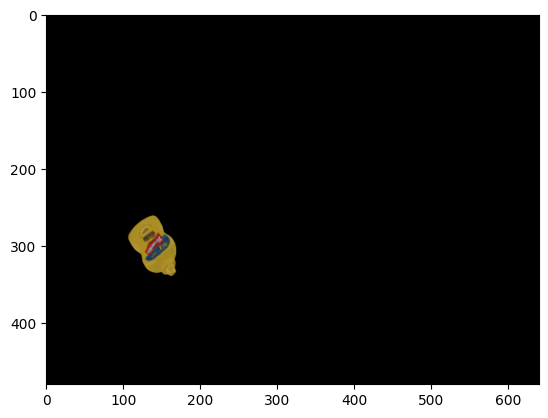

In [10]:
render_img = render_Gaussian_object_model(obj_gaussians, video_dataset.K, video_dataset.poses[0], video_dataset.H, video_dataset.W, device=device)
plt.imshow(render_img)
plt.show()

# 3. Load test data for pose estimaton and tracking

In [12]:
# query_video_camKs = list()
# with open(os.path.join(query_seq_dir, 'Frames.txt'), 'r') as cf:
#     for row in cf.readlines():
#         if len(row) > 0 and row[0] != '#':
#             camk_dat = np.array([float(c) for c in row.strip().split(',')])
#             camk = np.eye(3)
#             camk[0, 0] = camk_dat[-4]
#             camk[1, 1] = camk_dat[-3]
#             camk[0, 2] = camk_dat[-2]
#             camk[1, 2] = camk_dat[-1]
#             query_video_camKs.append(camk)
# query_video_frames = media.read_video(os.path.join(query_seq_dir, 'Frames.m4v')) # NxHxWx3    
# num_frames = len(query_video_frames)
# query_video_frames.shape
query_video_camKs = [video_dataset.K for _ in range(len(video_dataset))]
query_video_frames = np.array([video_dataset.get_rgb(i) for i in range(len(video_dataset))])
query_video_frames.shape

(737, 480, 640, 3)

## 3.1 Perform single-frame pose estimation

In [15]:
from tqdm import tqdm

CFG.MAX_STEPS = 400
CFG.START_LR = 5e-3
CFG.END_LR = 0

gsp_initial_poses = list()
gsp_poses = list()
gsp_video_frames = list()


scale = 1.45
thickness = 5
color = (255, 255, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

start_idx = 0
gsp_accum_runtime = 0
num_frames = len(query_video_frames)
for view_idx in tqdm(range(num_frames)):    
    camK = query_video_camKs[view_idx]
    image = query_video_frames[view_idx]
    image = torch.as_tensor(np.array(image), dtype=torch.float32) / 255.0
    
    camK = torch.as_tensor(camK, dtype=torch.float32)
    
    target_size = CFG.zoom_image_scale
    raw_hei, raw_wid = image.shape[:2]
    raw_long_size = max(raw_hei, raw_wid)
    raw_short_size = min(raw_hei, raw_wid)
    raw_aspect_ratio = raw_short_size / raw_long_size
    if raw_hei < raw_wid:
        new_wid = CFG.query_longside_scale
        new_hei = int(new_wid * raw_aspect_ratio)
    else:
        new_hei = CFG.query_longside_scale
        new_wid = int(new_hei * raw_aspect_ratio)
    query_rescaling_factor = CFG.query_longside_scale / raw_long_size
    que_image = image[None, ...].permute(0, 3, 1, 2).to(device)
    que_image = torch_F.interpolate(que_image, size=(new_hei, new_wid), mode='bilinear', align_corners=True)

    run_timer = time.time()
    
    obj_data = perform_segmentation_and_encoding(model_net, que_image, reference_database, device=device)
    obj_data['camK'] = camK.to(device)
    obj_data['img_scale'] = max(image.shape[:2])
    obj_data['bbox_scale'] /= query_rescaling_factor  # back to the original image scale
    obj_data['bbox_center'] /= query_rescaling_factor # back to the original image scale
    
    try:
        init_RTs = multiple_initial_pose_inference(obj_data, ref_database=reference_database, device=device)
    except Exception as e:
        print(e)
        init_RTs = torch.eye(4)[None].numpy()

    gsp_initial_poses.append(init_RTs)
        
    refiner_oupt = multiple_refine_pose_with_GS_refiner(
        obj_data, init_pose=init_RTs, gaussians=reference_database['obj_gaussians'], device=device)
            
    gsp_accum_runtime += time.time() - run_timer

    gsp_pose = refiner_oupt['refined_RT']
    iter_step = refiner_oupt['iter_step']
    bbox_scale = refiner_oupt['bbox_scale']
    bbox_center = refiner_oupt['bbox_center']
    gsp_render_frame = refiner_oupt['render_img']
    gsp_poses.append(gsp_pose)
    
    small_hei = raw_hei // 3 # downscale the image for visualization
    small_wid = raw_wid // 3
    
#     gsp_render_frame = render_Gaussian_object_model(obj_gaussians, camK=camK, pose=gsp_RT, 
#                                                     img_hei=raw_hei, img_wid=raw_wid, device=device)
    
    gsp_render_frame = gs_utils.zoom_out_and_uncrop_image(gsp_render_frame, # 3xSxS
                                                            bbox_scale=bbox_scale,
                                                            bbox_center=bbox_center,
                                                            orig_hei=image.shape[0],
                                                            orig_wid=image.shape[1],
                                                            ).detach().cpu().squeeze() # HxWx3
    gsp_render_frame = (torch.clamp(gsp_render_frame, 0, 1.0) * 255).numpy().astype(np.uint8)
    
    query_img_np = (image * 255).numpy().astype(np.uint8)
    gsp_RT = torch.as_tensor(gsp_pose, dtype=torch.float32)
    gsp_bbox_KRT = torch.einsum('ij,kj->ki', gsp_RT[:3, :3], cannon_3D_bbox.cpu()) + gsp_RT[:3, 3][None, :]
    gsp_bbox_KRT = torch.einsum('ij,kj->ki', camK, gsp_bbox_KRT)
    gsp_bbox_pts = (gsp_bbox_KRT[:, :2] / gsp_bbox_KRT[:, 2:3]).type(torch.int64)
    track_bbox_pts = gsp_bbox_pts.numpy()
    
    gsp_bbox3d_frame = query_img_np.copy()
    gsp_bbox3d_frame = gs_utils.draw_3d_bounding_box(gsp_bbox3d_frame, track_bbox_pts, color=color, linewidth=20)
    gsp_bbox3d_frame = cv2.resize(gsp_bbox3d_frame, (small_wid, small_hei))
        
    query_img_np = cv2.resize(query_img_np, (small_wid, small_hei))
    gsp_render_frame = cv2.resize(gsp_render_frame, (small_wid, small_hei))
    gsp_overlay_frame = cv2.addWeighted(
        cv2.cvtColor(gsp_render_frame.copy(), cv2.COLOR_BGR2HSV), 0.6, query_img_np, 0.4, 1)
            
    cv2.putText(query_img_np,     'Input Video', (100, 40), font, scale, color, thickness=thickness)
    cv2.putText(gsp_bbox3d_frame, 'Estimated Pose', (60, 40), font, scale, color, thickness=thickness)

    cv2.putText(gsp_render_frame,    'Gaussian rendering', (20, 40), font, scale, color, thickness=thickness)
    cv2.putText(gsp_render_frame,    'with estimated pose', (10, 80), font, scale, color, thickness=thickness)
    
    cv2.putText(gsp_overlay_frame, 'Overlay rendering', (40, 40), font, scale, color, thickness=thickness)
    cv2.putText(gsp_overlay_frame, 'on input image', (60, 80), font, scale, color, thickness=thickness)

    wihite_stripe = np.ones_like(gsp_bbox3d_frame)[:, :50, :] * 255    
    concat_frame = np.concatenate([gsp_bbox3d_frame, wihite_stripe,
                                   gsp_render_frame, wihite_stripe,
                                   gsp_overlay_frame], axis=1)
    gsp_video_frames.append(concat_frame)
    
    if (view_idx + 1) % 30 == 0:
        print('[{}/{}], \t refining_step:{}, \t {:.1f} FPS'.format(
            view_idx+1, num_frames, iter_step, (view_idx - start_idx) / gsp_accum_runtime))
    
gsp_video_frames = np.stack(gsp_video_frames, axis=0)
print(gsp_video_frames.shape)

  0%|          | 0/737 [00:00<?, ?it/s]

  4%|▍         | 30/737 [00:47<19:11,  1.63s/it]

[30/737], 	 refining_step:91, 	 0.6 FPS


  8%|▊         | 60/737 [01:34<16:35,  1.47s/it]

[60/737], 	 refining_step:83, 	 0.6 FPS


 12%|█▏        | 90/737 [02:24<18:26,  1.71s/it]

[90/737], 	 refining_step:103, 	 0.6 FPS


 16%|█▋        | 120/737 [03:16<19:32,  1.90s/it]

[120/737], 	 refining_step:89, 	 0.6 FPS


 20%|██        | 150/737 [04:06<17:00,  1.74s/it]

[150/737], 	 refining_step:93, 	 0.6 FPS


 24%|██▍       | 180/737 [04:57<15:58,  1.72s/it]

[180/737], 	 refining_step:91, 	 0.6 FPS


 28%|██▊       | 210/737 [05:46<15:10,  1.73s/it]

[210/737], 	 refining_step:95, 	 0.6 FPS


 33%|███▎      | 240/737 [06:34<13:09,  1.59s/it]

[240/737], 	 refining_step:89, 	 0.6 FPS


 37%|███▋      | 270/737 [07:24<12:55,  1.66s/it]

[270/737], 	 refining_step:94, 	 0.6 FPS


 41%|████      | 300/737 [08:13<10:46,  1.48s/it]

[300/737], 	 refining_step:78, 	 0.6 FPS


 45%|████▍     | 330/737 [08:56<10:14,  1.51s/it]

[330/737], 	 refining_step:83, 	 0.6 FPS


 49%|████▉     | 360/737 [09:50<11:03,  1.76s/it]

[360/737], 	 refining_step:91, 	 0.6 FPS


 53%|█████▎    | 390/737 [10:49<10:28,  1.81s/it]

[390/737], 	 refining_step:83, 	 0.6 FPS


 57%|█████▋    | 420/737 [11:53<07:26,  1.41s/it]

[420/737], 	 refining_step:74, 	 0.6 FPS


 61%|██████    | 450/737 [12:40<07:54,  1.65s/it]

[450/737], 	 refining_step:95, 	 0.6 FPS


 65%|██████▌   | 480/737 [13:29<07:09,  1.67s/it]

[480/737], 	 refining_step:105, 	 0.6 FPS


 69%|██████▉   | 510/737 [14:21<05:49,  1.54s/it]

[510/737], 	 refining_step:93, 	 0.6 FPS


 73%|███████▎  | 540/737 [15:16<06:13,  1.90s/it]

[540/737], 	 refining_step:87, 	 0.6 FPS


 77%|███████▋  | 570/737 [16:02<05:12,  1.87s/it]

[570/737], 	 refining_step:127, 	 0.6 FPS


 81%|████████▏ | 600/737 [16:45<03:28,  1.52s/it]

[600/737], 	 refining_step:85, 	 0.6 FPS


 85%|████████▌ | 630/737 [17:31<02:39,  1.49s/it]

[630/737], 	 refining_step:86, 	 0.6 FPS


 90%|████████▉ | 660/737 [18:17<02:04,  1.61s/it]

[660/737], 	 refining_step:89, 	 0.6 FPS


 94%|█████████▎| 690/737 [19:03<01:15,  1.61s/it]

[690/737], 	 refining_step:97, 	 0.6 FPS


 98%|█████████▊| 720/737 [19:52<00:25,  1.51s/it]

[720/737], 	 refining_step:91, 	 0.6 FPS


100%|██████████| 737/737 [20:18<00:00,  1.65s/it]

(737, 160, 739, 3)


In [22]:
fps = 15
media.show_video(np.stack(gsp_video_frames, axis=0), fps=fps, width=3*320)

# Save poses and initial poses to file
gsp_pose_file = os.path.join(demo_data_dir, f'{video_name}_gsp_poses.pkl')
gsp_init_pose_file = os.path.join(demo_data_dir, f'{video_name}_gsp_init_poses.pkl')
with open(gsp_pose_file, 'wb') as pf:
    pickle.dump(gsp_poses, pf)
with open(gsp_init_pose_file, 'wb') as ipf:
    pickle.dump(gsp_initial_poses, ipf)
print('Save poses to ', gsp_pose_file)
print('Save initial poses to ', gsp_init_pose_file)
# Save runtime to file
gsp_runtime_file = os.path.join(demo_data_dir, f'{video_name}_gsp_runtime.txt')
with open(gsp_runtime_file, 'w') as rf:
    rf.write(f'{gsp_accum_runtime:.2f}')
print('Save runtime to ', gsp_runtime_file)


Save poses to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard0_gsp_poses.pkl
Save initial poses to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard0_gsp_init_poses.pkl
Save runtime to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard0_gsp_runtime.txt


## 3.2 Perform pose tracking

In [21]:
# estimate the pose for the first frame
start_idx = 0
camK = query_video_camKs[start_idx]
image = query_video_frames[start_idx]
camK = torch.as_tensor(camK, dtype=torch.float32)
image = torch.as_tensor(np.array(image), dtype=torch.float32) / 255.0

target_size = CFG.zoom_image_scale
raw_hei, raw_wid = image.shape[:2]
raw_long_size = max(raw_hei, raw_wid)
raw_short_size = min(raw_hei, raw_wid)
raw_aspect_ratio = raw_short_size / raw_long_size
if raw_hei < raw_wid:
    new_wid = CFG.query_longside_scale
    new_hei = int(new_wid * raw_aspect_ratio)
else:
    new_hei = CFG.query_longside_scale
    new_wid = int(new_hei * raw_aspect_ratio)
query_rescaling_factor = CFG.query_longside_scale / raw_long_size
que_image = image[None, ...].permute(0, 3, 1, 2).to(device)
que_image = torch_F.interpolate(que_image, size=(new_hei, new_wid), mode='bilinear', align_corners=True)

obj_data = perform_segmentation_and_encoding(model_net, que_image, reference_database, device=device)
obj_data['camK'] = camK
obj_data['img_scale'] = max(image.shape[:2])
obj_data['bbox_scale'] /= query_rescaling_factor  # back to the original image scale
obj_data['bbox_center'] /= query_rescaling_factor # back to the original image scale

# init_pose = multiple_initial_pose_inference(obj_data, ref_database=reference_database, device=device)[0]
init_pose = video_dataset.get_gt_pose(start_idx)

scale = 1.45
thickness = 5
color = (255, 255, 0)
font = cv2.FONT_HERSHEY_SIMPLEX

track_poses = list()
track_video_frames = list()
track_pose = init_pose.copy()
num_frames = len(query_video_frames)
frame_interval = 1
track_accum_runtime = 0

CFG.MAX_STEPS = 64
CFG.START_LR = 3e-3
CFG.END_LR = 1e-5

for view_idx in tqdm(range(start_idx, num_frames, frame_interval)):    
    
    camK = query_video_camKs[view_idx]
    camK = torch.as_tensor(camK, dtype=torch.float32)

    image = query_video_frames[view_idx]
    image = torch.as_tensor(np.array(image), dtype=torch.float32) / 255.0


    image_hei, image_wid = image.shape[:2]
    
    track_timer = time.time()
    track_outp = GS_Tracker(model_net, frame=image, prev_pose=track_pose, 
                            camK=camK, ref_database=reference_database)
    frame_cost = time.time() - track_timer
    track_accum_runtime += frame_cost
    
    iter_step = track_outp['iter_step']
    render_img = track_outp['render_img']
    track_pose = track_outp['track_pose']
    bbox_scale = track_outp['bbox_scale']
    bbox_center = track_outp['bbox_center']
    track_poses.append(track_pose)
    small_hei = image_hei // 3
    small_wid = image_wid // 3
    
    render_full_img = gs_utils.zoom_out_and_uncrop_image(render_img, # 3xSxS
                                                            bbox_scale=bbox_scale,
                                                            bbox_center=bbox_center,
                                                            orig_hei=image.shape[0],
                                                            orig_wid=image.shape[1],
                                                            ).detach().cpu().squeeze() # HxWx3
    render_full_img_np = (torch.clamp(render_full_img, 0, 1.0) * 255).numpy().astype(np.uint8)
    
    query_img_np = (image * 255).numpy().astype(np.uint8)
    track_render_img = render_full_img_np.copy()
    
    track_overlap_frame = cv2.cvtColor(track_render_img.copy(), cv2.COLOR_BGR2HSV)
    track_overlap_frame = cv2.addWeighted(track_overlap_frame, 0.6, query_img_np, 0.4, 1)
        
    track_RT = torch.as_tensor(track_pose, dtype=torch.float32)
    track_bbox_KRT = torch.einsum('ij,kj->ki', track_RT[:3, :3], cannon_3D_bbox) + track_RT[:3, 3][None, :]
    track_bbox_KRT = torch.einsum('ij,kj->ki', camK, track_bbox_KRT)
    track_bbox_pts = (track_bbox_KRT[:, :2] / track_bbox_KRT[:, 2:3]).type(torch.int64)
    track_bbox_pts = track_bbox_pts.numpy()
    track_bbox3d_img = query_img_np.copy()
    track_bbox3d_img = gs_utils.draw_3d_bounding_box(track_bbox3d_img, track_bbox_pts, color=color, linewidth=20)

    
    query_img_np = cv2.resize(query_img_np, (small_wid, small_hei))
    track_bbox3d_img = cv2.resize(track_bbox3d_img, (small_wid, small_hei))
    track_render_frame = cv2.resize(track_render_img, (small_wid, small_hei))
    track_overlap_frame = cv2.resize(track_overlap_frame, (small_wid, small_hei))
        
    
    cv2.putText(query_img_np,     '  Input Video  ', (60, 50), font, scale, color, thickness=thickness)
    cv2.putText(track_bbox3d_img, 'Tracking Result', (60, 50), font, scale, color, thickness=thickness)
    
    cv2.putText(track_overlap_frame, 'Overlay rendering', (40, 40), font, scale, color, thickness=thickness)
    cv2.putText(track_overlap_frame, 'on input image', (60, 80), font, scale, color, thickness=thickness)
    
    cv2.putText(track_render_frame, 'Gaussian rendering', (20, 40), font, scale, color, thickness=thickness)
    cv2.putText(track_render_frame, 'with estimated pose', (10, 80), font, scale, color, thickness=thickness)
    
    wihite_stripe = np.ones_like(query_img_np)[:, :50, :] * 255    
    
    concat_images = np.concatenate([query_img_np, wihite_stripe,
                                    track_bbox3d_img, wihite_stripe,
                                    track_render_frame, wihite_stripe,
                                    track_overlap_frame], axis=1)
    track_video_frames.append(concat_images)
    
    if (view_idx + 1) % 30 == 0:
        print('[{}/{}], \t{:.1f} FPS'.format(view_idx+1, num_frames, (view_idx - start_idx) / track_accum_runtime))

        

  4%|▍         | 30/737 [00:12<04:55,  2.39it/s]

[30/737], 	2.4 FPS


  8%|▊         | 60/737 [00:24<04:20,  2.60it/s]

[60/737], 	2.5 FPS


 12%|█▏        | 90/737 [00:37<04:37,  2.33it/s]

[90/737], 	2.4 FPS


 16%|█▋        | 120/737 [00:51<05:01,  2.05it/s]

[120/737], 	2.4 FPS


 20%|██        | 150/737 [01:03<04:07,  2.37it/s]

[150/737], 	2.4 FPS


 24%|██▍       | 180/737 [01:15<03:34,  2.60it/s]

[180/737], 	2.4 FPS


 28%|██▊       | 210/737 [01:27<03:33,  2.47it/s]

[210/737], 	2.4 FPS


 33%|███▎      | 240/737 [01:38<03:10,  2.61it/s]

[240/737], 	2.5 FPS


 37%|███▋      | 270/737 [01:51<03:06,  2.51it/s]

[270/737], 	2.5 FPS


 41%|████      | 300/737 [02:02<02:25,  3.00it/s]

[300/737], 	2.5 FPS


 45%|████▍     | 330/737 [02:12<02:10,  3.11it/s]

[330/737], 	2.5 FPS


 49%|████▉     | 360/737 [02:23<02:26,  2.58it/s]

[360/737], 	2.5 FPS


 53%|█████▎    | 390/737 [02:33<01:54,  3.04it/s]

[390/737], 	2.6 FPS


 57%|█████▋    | 420/737 [02:45<02:11,  2.42it/s]

[420/737], 	2.6 FPS


 61%|██████    | 450/737 [02:56<01:22,  3.50it/s]

[450/737], 	2.6 FPS


 65%|██████▌   | 480/737 [03:07<01:26,  2.97it/s]

[480/737], 	2.6 FPS


 69%|██████▉   | 510/737 [03:18<01:14,  3.04it/s]

[510/737], 	2.6 FPS


 73%|███████▎  | 540/737 [03:28<01:13,  2.67it/s]

[540/737], 	2.6 FPS


 77%|███████▋  | 570/737 [03:41<01:12,  2.30it/s]

[570/737], 	2.6 FPS


 81%|████████▏ | 600/737 [03:55<01:01,  2.23it/s]

[600/737], 	2.6 FPS


 85%|████████▌ | 630/737 [04:07<00:39,  2.69it/s]

[630/737], 	2.6 FPS


 90%|████████▉ | 660/737 [04:17<00:27,  2.85it/s]

[660/737], 	2.6 FPS


 94%|█████████▎| 690/737 [04:29<00:16,  2.92it/s]

[690/737], 	2.6 FPS


 98%|█████████▊| 720/737 [04:40<00:05,  3.18it/s]

[720/737], 	2.6 FPS


100%|██████████| 737/737 [04:46<00:00,  2.58it/s]


In [23]:
media.show_video(np.stack(track_video_frames, axis=0), fps=24, width=320*3)

# Save track poses to file
track_pose_file = os.path.join(demo_data_dir, f'{video_name}_gsp_track_poses.pkl')
with open(track_pose_file, 'wb') as pf:
    pickle.dump(track_poses, pf)
print('Save poses to ', track_pose_file)
# Save runtime to file
track_runtime_file = os.path.join(demo_data_dir, f'{video_name}_gsp_track_runtime.txt')
with open(track_runtime_file, 'w') as rf:
    rf.write(f'{track_accum_runtime:.2f}')
print('Save runtime to ', track_runtime_file)

Save poses to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard0_gsp_track_poses.pkl
Save runtime to  /home/jafonso/Documents/repositories/GSPose/data/inputs/mustard0/mustard0_gsp_track_runtime.txt


# 4. Visualize the coordinate pointcloud of the 3D Gaussian object model

In [ ]:
obj_gaussian_pointcloud = py3d_struct.Pointclouds(
    points=[obj_gaussians.get_xyz.squeeze().detach().cpu()],
    features=[obj_gaussians._features_dc.squeeze().detach().cpu().sigmoid()]
)

fig = py3d_vis.plot_scene(
    {" ": 
        {
            'Gaussian pointcloud': obj_gaussian_pointcloud,
        }
    },
    xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
    yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
    zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
    
#     xaxis={"backgroundcolor":"rgb(255, 255, 255)"},
#     yaxis={"backgroundcolor":"rgb(255, 255, 255)"},
#     zaxis={"backgroundcolor":"rgb(255, 255, 255)"}, 
    
    pointcloud_marker_size=3,
    pointcloud_max_points=30_000,
    axis_args=py3d_vis.AxisArgs(showgrid=True)
)

fig.update_layout(width=800, height=600)
fig.show()

